In [30]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths for your local environment
zip_path = "C:\\Users\\tadak\\OneDrive\\Desktop\\Data analysis\\work\\Challenge\\Project 4\\Project4\\Sample_BrainTumor_images.zip"
extraction_path = "C:\\Users\\tadak\\OneDrive\\Desktop\\Data analysis\\work\\Challenge\\Project 4\\Project4\\brain_tumor_images"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Confirm extraction by listing directories
print("Extracted files and folders:", os.listdir(extraction_path))

# Image resizing and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Set up data generators with data augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # Using 30% for validation
)

# Load training and validation data
train_data = data_gen.flow_from_directory(
    extraction_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = data_gen.flow_from_directory(
    extraction_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Print details about the training and validation datasets
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")


Extracted files and folders: ['Sample_BrainTumor_images']
Found 56 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Training samples: 56
Validation samples: 24


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 57600)             0         
                                                                 
 dense_28 (Dense)            (None, 64)              

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Start with more epochs; early stopping will cut it if overfitting
    callbacks=[early_stopping]
)

# Save the model
model.save('brain_tumor_detector.h5')


Epoch 1/20
2/2 [==============================] - 2s 773ms/step - loss: 2.0660 - accuracy: 0.7679 - val_loss: 1.3936 - val_accuracy: 1.0000
Epoch 2/20
2/2 [==============================] - 1s 384ms/step - loss: 1.3290 - accuracy: 1.0000 - val_loss: 1.1175 - val_accuracy: 1.0000
Epoch 3/20
2/2 [==============================] - 1s 513ms/step - loss: 1.0596 - accuracy: 1.0000 - val_loss: 0.9360 - val_accuracy: 1.0000
Epoch 4/20
2/2 [==============================] - 1s 398ms/step - loss: 0.9093 - accuracy: 1.0000 - val_loss: 0.8259 - val_accuracy: 1.0000
Epoch 5/20
2/2 [==============================] - 1s 430ms/step - loss: 0.8049 - accuracy: 1.0000 - val_loss: 0.7602 - val_accuracy: 1.0000
Epoch 6/20
2/2 [==============================] - 1s 435ms/step - loss: 0.7500 - accuracy: 1.0000 - val_loss: 0.7153 - val_accuracy: 1.0000
Epoch 7/20
2/2 [==============================] - 1s 413ms/step - loss: 0.7066 - accuracy: 1.0000 - val_loss: 0.6745 - val_accuracy: 1.0000
Epoch 8/20
2/2 [====

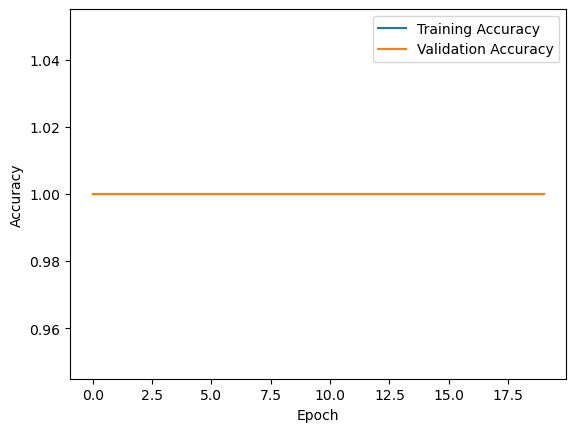

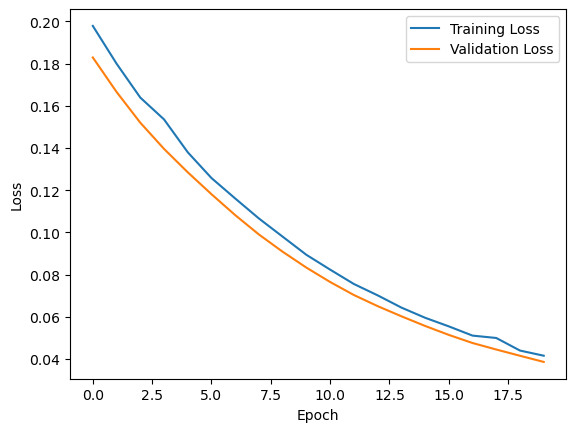

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
import os  # Import os module to handle file paths
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
model = load_model('improved_brain_tumor_detector.h5')

# Define the list of image paths you want to process
image_files = [
    '/mnt/data/image(19).jpg', '/mnt/data/image(21).jpg', '/mnt/data/image(26).jpg',
    '/mnt/data/image(31).jpg', '/mnt/data/image(36).jpg', '/mnt/data/image(61).jpg',
    '/mnt/data/image(74).jpg', '/mnt/data/image(78).jpg', '/mnt/data/image(87).jpg',
    '/mnt/data/image(94).jpg'
]

# Initialize an empty list to store results
results = []

# Loop through each image, process it, and make predictions
IMG_SIZE = (128, 128)  # Model input size
for file_path in image_files:
    # Check if the file exists before processing
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Read and preprocess the image
    img = cv2.imread(file_path)
    if img is None:
        print(f"Could not load image: {file_path}")
        continue
    
    # Resize and preprocess
    img = cv2.resize(img, IMG_SIZE)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    label = "Tumor detected" if prediction > 0.5 else "No tumor detected"

    # Append result to the list
    results.append({
        "Filename": file_path.split('/')[-1],  # Just the file name
        "Prediction": label,
        "Probability": float(prediction)  # Model's prediction probability
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df

# Save the results to a CSV file
results_df.to_csv('predictions_log.csv', index=False)
print("Results saved to predictions_log.csv")

image_files = [
    'C:\\Users\\YourUsername\\Desktop\\Data analysis\\work\\Challenge\\Project 4\\Project4\\image(19).jpg',
    'C:\\Users\\YourUsername\\Desktop\\Data analysis\\work\\Challenge\\Project 4\\Project4\\image(21).jpg',
    'C:\\Users\\YourUsername\\Desktop\\Data analysis\\work\\Challenge\\Project 4\\Project4\\image(26).jpg',
    # Add other image paths similarly
]


File not found: /mnt/data/image(19).jpg
File not found: /mnt/data/image(21).jpg
File not found: /mnt/data/image(26).jpg
File not found: /mnt/data/image(31).jpg
File not found: /mnt/data/image(36).jpg
File not found: /mnt/data/image(61).jpg
File not found: /mnt/data/image(74).jpg
File not found: /mnt/data/image(78).jpg
File not found: /mnt/data/image(87).jpg
File not found: /mnt/data/image(94).jpg
Results saved to predictions_log.csv
